In [1]:
import json

def dump_jsonl(data, output_path, append=False, progress=False):
    """
    Write list of objects to a JSON lines file.
    """
    mode = 'a+' if append else 'w'
    with open(output_path, mode, encoding='utf-8') as f:
        if progress:
            data = tqdm(data)
            
        for line in data:
            json_record = json.dumps(line, ensure_ascii=False)
            f.write(json_record + '\n')
    print('Wrote {} records to {}'.format(len(data), output_path))

def load_jsonl(input_path, verbose=True, progress=False) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        if progress:
            f = tqdm(f)
            
        for line in f:
                data.append(json.loads(line.rstrip('\n|\r')))
    
    if verbose:
        print('Loaded {} records from {}'.format(len(data), input_path))
        
    return data


# Load conversaions

In [2]:
conversations = load_jsonl("twarc2_conversation.jsonl")

Loaded 3391 records from twarc2_conversation.jsonl


In [3]:
tweets = load_jsonl(f"conversations/tweets_v2.jsonl")

Loaded 185750 records from conversations/tweets_v2.jsonl


In [4]:
id2tweet = {}
for tweet in tweets:
    if tweet is None:
        continue
        
    if type(tweet)==list:
        id2tweet[tweet[0]["value"]] = tweet[0]
        continue

    if "id" not in tweet:
        id2tweet[tweet["resource_id"]] = tweet
        continue

    id2tweet[tweet["id"]] = tweet
    if "expansions" in tweet:
        for expantion_tweet in tweet["expansions"]["tweets"]:
            id2tweet[expantion_tweet["id"]] = expantion_tweet


## Get conversation graph

In [6]:
def get_tweet_graph(conversation):
    
    tweet_graph = defaultdict(list)

    for tweet in conversation:
        for parent_tweet in tweet["referenced_tweets"]:
#             if parent_tweet["type"]=="quoted":
#                 continue
            tweet_graph[parent_tweet["id"]].append(tweet["id"])
                
    return tweet_graph

def get_path(curr, tweet_graph):
    if curr not in tweet_graph:
        return [f"{curr}"]

    if len(tweet_graph[curr])==0:
        return [f"{curr}"]

    paths = []
    for next_tweet in tweet_graph[curr]:
        next_paths = get_path(next_tweet, tweet_graph)
        for path in next_paths:
            paths.append(f"{curr} > {path}")
    return paths

In [7]:
from collections import defaultdict

n_path = 0
n_skip = 0

path_depth = []
user_count = []
selected_paths = []
for conv in conversations:
    tweet_graph = get_tweet_graph(conv["data"])
    paths = get_path(conv["data"][0]["conversation_id"], tweet_graph)

    for p in paths:
        n_path += 1
        tweetids = p.split(" > ")
        
        user_ids_in_conv = set()
        for twid in tweetids:
            if twid not in id2tweet:
                user_ids_in_conv.add("deleted")
                continue
            elif id2tweet[twid] is None:
                user_ids_in_conv.add("deleted")
                continue
            elif "author_id" not in id2tweet[twid]:
                user_ids_in_conv.add("unknown")
                continue
            else:
                user_ids_in_conv.add(id2tweet[twid]["author_id"])
        
        nuser = len(user_ids_in_conv)
        if "unknown" in user_ids_in_conv:
            nuser -= 1
        
        if nuser==1:
            n_skip += 1
            continue
        
        if len(tweetids) > 10:
            n_skip += 1
            continue
            
        selected_paths.append(tweetids)
        path_depth.append(len(tweetids))
        user_count.append(nuser)

In [28]:
import random
import re

def htmlspecialchars(text):
    return (
        text.replace("&amp;", "&").
        replace("&quot;", '"').
        replace("&lt;", "<").
        replace("&gt;", ">")
    )

rows = []
for path in selected_paths:
    
    text = []
    userid = {}
    skip = False
    if len(path) <= 2:
        continue
        
    for twid in path:
        if twid not in id2tweet:
            skip = True
            break
            
        tweet = id2tweet[twid]
        if tweet is None:
            skip = True
            break
            
        if "author_id" not in tweet:
            # text.append(("unknown", tweet["text"]))
            skip = True
            break
        
        
        userid[tweet["author_id"]] = True
        text.append((tweet["author_id"], tweet["text"]))
        
    if skip:
        continue
        
    userid2name = {"unknown":"???"}
    
    if len(userid) > 2:
        continue
        
    for idx, u in enumerate(userid):
        userid2name[u] = chr(ord("A")+idx)
    
    if text[0][0] == text[1][0]: 
        continue
        
    s = ""
    for t in text:
        tt = ' '.join(re.sub("(@[A-Za-z0-9_]+)|(\w+:\/\/\S+)"," ", t[1]).split())
        tt = htmlspecialchars(tt)
        s += f"{userid2name[t[0]]}: {tt}\n\n"

    rows.append({
        "text": s,
        "label": [],
        "path": ">".join(path),
        "tweet": f"https://twitter.com/i/web/status/{path[-1]}",
        "user": set([t[0] for t in text])
    })
    
random.Random(41).shuffle(rows)

In [29]:
rows[50]

{'text': 'A: ใครอารมณ์ดี มาดูคลิปนี้ ไม่ถึงนาที คิ้วขมวดแบบอยากต่อยกำแพง\n\nB: \n\nB: \n\nB: \n\n',
 'label': [],
 'path': '1582717046650830848>1583441018363338753>1583441668979585024>1583442127739973632',
 'tweet': 'https://twitter.com/i/web/status/1583442127739973632',
 'user': {'423283880', '999556736854867968'}}

In [34]:
import pandas as pd

_df = []
for row in rows:
    _df.append({
        "text": row["text"],
        "tweet": row["tweet"],
        "path": row["path"],
        
    })
    
df = pd.DataFrame(_df)

## Load Annotated

Loaded 1000 records from annotated/v1.0/authority_1.0/arm.jsonl


<function pandas.core.dtypes.missing.isna(obj)>

In [53]:
_df = []
annotated = load_jsonl("annotated/v1.0/authority_1.0/arm.jsonl")

def authority_to_degree(label):
    if label == 'B ให้เกียรติ':
        return 1
    elif label == 'B ทำตัวปกติ':
        return 0.5
    elif label == 'B ไม่ให้เกียรติกัน':
        return 0
    else:
        return None
    
for row in annotated:
    if len(row["label"])==0:
        continue
        
    _df.append({
        "text": row["text"],
        "tweet": row["tweet"],
        "authority": row["label"][0],
        "authority_degree": authority_to_degree(row["label"][0])
    })
    
    
    
auth_df = pd.DataFrame(_df)

Loaded 1000 records from annotated/v1.0/authority_1.0/arm.jsonl


In [54]:
ls annotated/v1.0/

authority_1.0/ closeness_1.0/


In [62]:
_df = []
annotated = load_jsonl("annotated/v1.0/closeness_1.0/arm.jsonl")

def closeness_to_degree(label):
    if label == 'สนิทกันมาก':
        return 1
    elif label == 'แค่คนรู้จักกัน':
        return 0.75
    elif label == 'ไม่รู้จักกัน':
        return 0.5
    elif label == 'ไม่ชอบหน้ากัน':
        return 0
    else:
        return None
    
for row in annotated:
    if len(row["label"])==0:
        continue
        
    _df.append({
#         "text": row["text"],
        "tweet": row["tweet"],
        "closeness": row["label"][0],
        "closeness_degree": closeness_to_degree(row["label"][0])
    })
    
    
    
close_df = pd.DataFrame(_df)

Loaded 1000 records from annotated/v1.0/closeness_1.0/arm.jsonl


In [63]:
annotated_df = pd.merge(auth_df, close_df, on="tweet")

In [71]:
assert(annotated_df["tweet"].nunique()==len(annotated_df))

In [75]:
df.columns

Index(['text', 'tweet', 'path'], dtype='object')

In [80]:
merged_df = pd.merge(df, annotated_df.drop(["text"], axis=1), on="tweet", how="left")

In [92]:
# len(merged_df[~pd.isna(merged_df["authority"])])

# Load Users

## Run Heuristic

In [141]:
import json
def load_jsonfile(filename):
    data = None
    try:
        with open(filename, encoding="utf-8") as fin:
            data = json.load(fin)
        
        if "meta" not in data:
            raise Exception("ERROR")
    except:
        data = {
            "data": [],
            "meta": {"result_count": 0}
        }
        
    return data

def getUserAB(row):
    twids = row["path"].split(">")
    userA = id2tweet[twids[0]]["author_id"]
    userB = None
    
    for twid in twids:
        uid = id2tweet[twid]["author_id"]
        if uid != userA:
            userB = uid
    return userA, userB

def estimate_closeness(row):
    userA, userB = getUserAB(row)
    friendA = load_jsonfile(f"./followings/{userA}.json")
    friendB = load_jsonfile(f"./followings/{userB}.json")

    NA = friendA["meta"]["result_count"]
    NB = friendB["meta"]["result_count"]
    
    if NA==0 or NB==0:
        return None
    
    fuidA = set()
    for friend in friendA["data"]:
        fuidA.add(friend["id"])
    
    fuidB = set()
    for friend in friendB["data"]:
        fuidB.add(friend["id"])

    common_friends = fuidA.intersection(fuidB)
    
    # scale len(common_friends) because data is sampled
    if NB<=500:
        ncommon = len(common_friends)*NA/len(friendA["data"])  
    elif NA <=500:
        ncommon = len(common_friends)*NB/len(friendB["data"])
    else:
        if NB > NA:
            ncommon = len(common_friends)*NA/len(friendA["data"]) 
        else:
            ncommon = len(common_friends)*NB/len(friendB["data"])
            
    return ncommon/min(NA, NB)

merged_df.head(10).apply(estimate_closeness, axis=1)

0    0.000000
1    0.041667
2         NaN
3    0.000000
4    0.372881
5    0.009091
6    0.000000
7    0.059406
8    0.269841
9    0.014451
dtype: float64

In [146]:
def estimate_authority(row):
    userA, userB = getUserAB(row)
    friendA = load_jsonfile(f"./followers/{userA}.json")
    friendB = load_jsonfile(f"./followers/{userB}.json")
    
    NA = friendA["meta"]["result_count"]
    NB = friendB["meta"]["result_count"]

    if NA==0 or NB==0:
        return None
    
    return min(NB/NA, 1)

merged_df.head(10).apply(estimate_authority, axis=1)

0         NaN
1    0.897778
2    0.307692
3    1.000000
4    0.685000
5    0.340000
6    0.008219
7    1.000000
8    0.872000
9    0.884250
dtype: float64

In [144]:
merged_df["est_closeness"] = merged_df.apply(estimate_closeness, axis=1)

In [147]:
merged_df["est_authority"] = merged_df.apply(estimate_authority, axis=1)

In [ ]:
"DONE"

In [150]:
valid_df = merged_df.dropna()

In [160]:
from scipy import stats

In [158]:
stats.spearmanr(valid_df["closeness_degree"].values, valid_df["est_closeness"].values)

SpearmanrResult(correlation=0.09667214581380294, pvalue=0.007982501899180601)

In [159]:
stats.spearmanr(valid_df["authority_degree"].values, valid_df["est_authority"].values)

SpearmanrResult(correlation=0.0784956330538063, pvalue=0.03137399152280078)

In [164]:
# valid_df.groupby("closeness_degree").average(["est_closeness"])

array([[<AxesSubplot:title={'center':'0.0'}>,
        <AxesSubplot:title={'center':'0.5'}>],
       [<AxesSubplot:title={'center':'0.75'}>,
        <AxesSubplot:title={'center':'1.0'}>]], dtype=object)

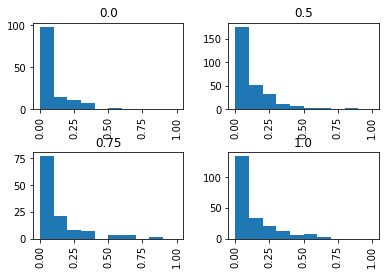

In [168]:
valid_df['est_closeness'].hist(by=valid_df['closeness_degree'], range=(0, 1))

array([[<AxesSubplot:title={'center':'0.0'}>,
        <AxesSubplot:title={'center':'0.5'}>],
       [<AxesSubplot:title={'center':'1.0'}>, <AxesSubplot:>]],
      dtype=object)

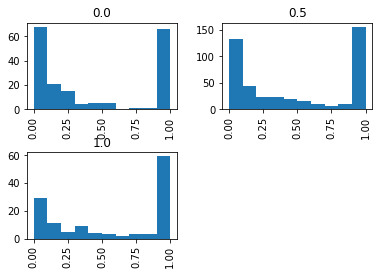

In [169]:
valid_df['est_authority'].hist(by=valid_df['authority_degree'], range=(0, 1))